In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_compression as tfc
import matplotlib.pyplot as plt

import os
import h5py

from BalleFFP_improved import BalleFFP
from BalleHP  import BalleHP
from read_data import read_data_numpy

In [2]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"]   = 14

In [4]:
MODEL_FOLDER = "../models/"
MODEL = "ffp"
CH_FORMAT = "channels_last"
EPOCHS = 5
NORM = False
DATIME = None

if DATIME is None:
    files = []
    for file in next(os.walk(MODEL_FOLDER))[2]:
        if f'model_{MODEL}_{CH_FORMAT}_epochs{EPOCHS}_norm{NORM}' in file:
            files.append(file[6:])
    
    SELECTED_MODEL = files[0]
else:
    SELECTED_MODEL = f'model_{MODEL}_{CH_FORMAT}_epochs{EPOCHS}_norm{NORM}_{DATIME}.h5'
    
print(SELECTED_MODEL)
MODEL_NAME   = "model_" + SELECTED_MODEL
LOSS_NAME    = "losses_" + SELECTED_MODEL

DATA_FOLDER  = "../data/stl10/stl10_binary/"
DATA_FILE    = "unlabeled_X.bin"

ffp_channels_last_epochs5_normFalse_l0.5_20230306172822.h5


In [5]:
model_path = os.path.join(MODEL_FOLDER, MODEL_NAME)
loss_path  = os.path.join(MODEL_FOLDER, LOSS_NAME)

In [6]:
model_path_2 = '../vae/vae_image_compression_weights'

## Train/Test loss

In [7]:
# open the .h5 file containing the losses and load them as two numpy arrays train_loss and test_loss
with h5py.File(loss_path, 'r') as f: # type: ignore
    train_loss = np.array(f['train'])
    test_loss  = np.array(f['test'])

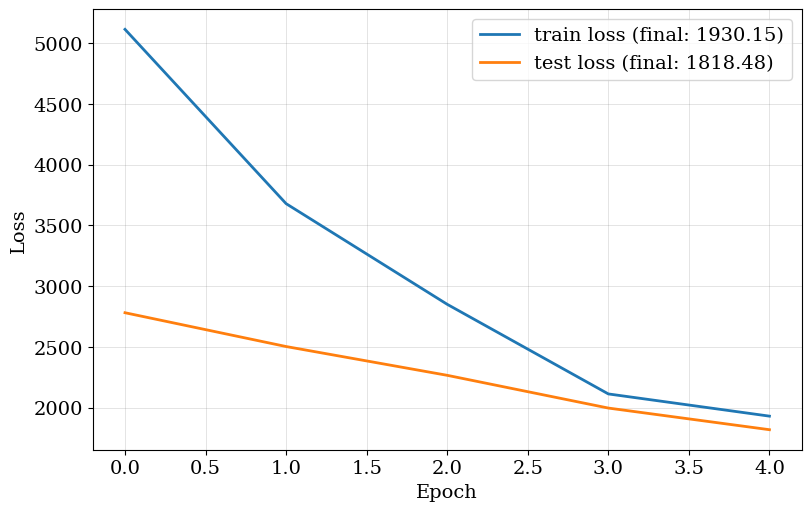

In [8]:
from cProfile import label


fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
ax.grid(True, which='both', ls='-', lw=0.5, c='grey', alpha=0.3)

ax.plot(train_loss, lw=2, label=f"train loss (final: {train_loss[-1]:.2f})")
ax.plot(test_loss,  lw=2, label=f"test loss (final: {test_loss[-1]:.2f})")

ax.legend()

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

fig.savefig("./plots/losses.png", dpi=300, facecolor="w")

plt.show()

## Model

In [9]:
tf.config.set_visible_devices([], 'GPU')

2023-03-06 17:30:17.720547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 17:30:17.722974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 17:30:17.734785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 17:30:17.736744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 17:30:17.738697: I tensorflow/compiler/xla/stream_executo

In [10]:
vae = BalleFFP(N=128, M=192, k2=3, c=3, format=CH_FORMAT)
vae_2 = BalleHP(N=128, M=192, k1=3, k2=3, c=3, format=CH_FORMAT)

_ = vae(tf.zeros((1, 96, 96, 3)))
_ = vae_2(tf.zeros((1, 96, 96, 3)))

# load the weights from the .h5 file
vae.load_weights(model_path)
vae_2.load_weights(model_path_2)

2023-03-06 17:30:20.041990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
data_path = os.path.join(DATA_FOLDER, DATA_FILE)
data = read_data_numpy(data_path, CH_FORMAT).astype('float32') 

In [18]:
def select_random_images(data, n):
    """Selects n random images from the data."""
    idx = np.random.choice(data.shape[0], n, replace=False)
    return data[idx]

img = select_random_images(data, 1)

In [13]:
def visualize_images(images, format):
    """Visualize images in a grid of 4 rows x 4 columns."""
    # Create a list of 16 images by random sampling from the dataset first dimension without replacement
    image_list = [images[i] for i in np.random.choice(images.shape[0], 16, replace=False)]
    if format=='channels_first':
        image_list = [np.transpose(image, (1, 2, 0)) for image in image_list]
    
    # check if the images are normalized
    norm = np.max(image_list) <= 1.0

    # Create a 4x4 grid of images
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat): # type: ignore
        if norm:
            ax.imshow(image_list[i]) # no need to convert to uint8
        else:
            ax.imshow(image_list[i].astype(np.uint8)) # convert to uint8 for visualization
        ax.axis('off')

    # Show the plot
    plt.show()

In [14]:
def image_comparison(img, reco, format):
    """Visualize the original image and the reconstructed image side by side."""
    if format=='channels_first':
        img = np.transpose(img, (1, 2, 0))
        reco = np.transpose(reco, (1, 2, 0))
    
    # check if the images are normalized
    norm_img  = np.max(img)  <= 1.0
    norm_reco = np.max(reco) <= 1.0

    # Create a 4x4 grid of images
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    axes[0].imshow(img if norm_img else img.astype(np.uint8)) # convert to uint8 for visualization
    axes[1].imshow(reco if norm_reco else reco.astype(np.uint8)) # convert to uint8 for visualization
    
    axes[0].axis('off')
    axes[1].axis('off')

    # Show the plot
    plt.show()

In [19]:
img_reco, rate_reco = vae(img, training=False)

img_reco_2, rate_reco_2i, rate_reco_2b = vae_2(img, training=False)

In [20]:
#img      = np.squeeze(img, axis=0)
img_reco = tf.squeeze(img_reco, axis=0).numpy()

img_reco_2 = tf.squeeze(img_reco_2, axis=0).numpy()

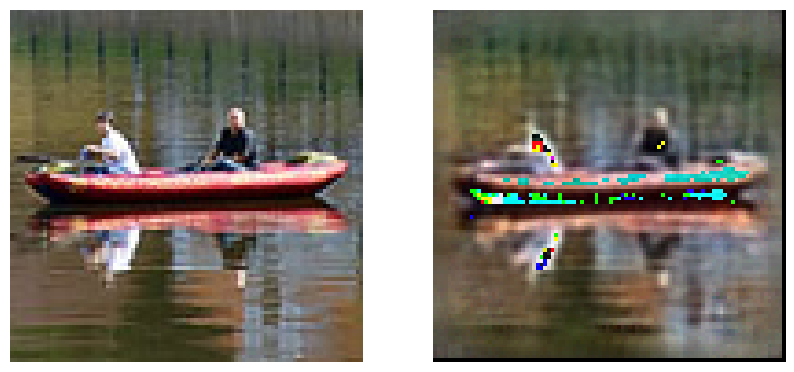

In [21]:
image_comparison(np.squeeze(img, axis=0), img_reco, CH_FORMAT)

## Coding efficiency FFP

In [22]:
class Compressor(tf.keras.Model):

    def __init__(self, model):

        super(Compressor, self).__init__()

        self.encoder = model.encoder
        self.prior   = model.prior
        self.bemodel = tfc.ContinuousBatchedEntropyModel(
            prior = self.prior,
            coding_rank=1,
            compression=True
        )

    def call(self, inputs):

        encoded = self.encoder(inputs, training=False)

        _, bits   = self.bemodel(encoded, training=False)
        bitstring = self.bemodel.compress(encoded)

        return bitstring, bits

In [24]:
compressor = Compressor(vae)

bitstrings, rates = compressor(img)

In [26]:
bitstrings[0, 0, 0].numpy().hex()

'92b516e922d71a958d6749ba61ede96a1ee6f9268da527d1f090cc29ff966e03722f9c94af17a231d5b80358a4365f339934edf1cd7bc63c7de773be5abee4e7c4ac17413d0f1b71aa9d000d5fe0bbfaebb0643fc1be9ba48dfc7d144071f6568ae5988f2234a923c8cdfd05cd8ae1c59a172f22f6220afbc9a8b9cc175723d7c5'

In [28]:
tf.reduce_mean(rates).numpy()

1030.5355

In [45]:
bemodel = tfc.ContinuousBatchedEntropyModel(
    prior=tfc.distributions.NoisyDeepFactorized(),
    coding_rank=3,
    compression=True
)

bemodel.get_config()
bemodel.set_weights(vae.bemodel.get_weights())

ValueError: `set_weights` expects a list of 11 arrays, received 8.

In [51]:
len(bemodel.compress(encoded_img)[0, 2, 6].numpy())

13

In [48]:
img_reco_2[img_reco_2 <= 0.]

array([], dtype=float32)

TensorShape([1, 192, 19, 19])

In [ ]:
vae.bemodel.compress(encoded_img)

RuntimeError: For range coding, the entropy model must be instantiated with `compression=True`.

In [ ]:
vae.bemodel.get_weights()

[array([[[0.3477062 ],
         [0.06208622],
         [0.33013475]]], dtype=float32),
 array([[[-0.3699839 ],
         [ 0.39880884],
         [ 0.41399515]]], dtype=float32),
 array([[[-0.4717313]]], dtype=float32),
 array([[[0.],
         [0.],
         [0.]]], dtype=float32),
 array([[[0.],
         [0.],
         [0.]]], dtype=float32),
 array([[[-1.7877836],
         [-1.7877836],
         [-1.7877836]]], dtype=float32),
 array([[[-1.7877836, -1.7877836, -1.7877836],
         [-1.7877836, -1.7877836, -1.7877836],
         [-1.7877836, -1.7877836, -1.7877836]]], dtype=float32),
 array([[[-0.5264881, -0.5264881, -0.5264881]]], dtype=float32)]